# Install library

# Xây dựng mô hình dịch máy cho cặp ngôn ngữ Anh - Việt

In [ ]:
!pip install nltk
!pip install underthesea
!pip install PyICU

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.9/20.9 MB 61.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 56.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 657.7/657.7 KB 48.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 267.7/267.7 KB 9.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for PyICU: filename=pyicu-2.15.2-cp37-cp37m-linux_x86_64.whl size=3796984 sha256=6937cbb6d22d81646fdf09aa9a5e97e92807becf1349aa6a8015b12a1079e7b4
  Stored in directory: /root/.cache/pip/wheels/ff/e6/9e/a11cffd7fb25d0a8894ecfae2cb1b01e35c88ec150e1133c59
Successfully built PyICU


In [ ]:
!pip install transformers sentence-transformers pandas scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 KB 4.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125938 sha256=f2f2440424d68d1aeb4f5d679368db5537d59d559a1c077f5e971e3f4e209c31
  Stored in directory: /root/.cache/pip/wheels/bf/06/fb/d59c1e5bd1dac7f6cf61ec0036cc3a10ab8fecaa6b2c3d3ee9
Successfully built sentence-transformers


In [ ]:
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /usr/share/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

# Library

In [4]:
import numpy as np
import pandas as pd
import string

from underthesea import word_tokenize
from nltk.tokenize import word_tokenize

import icu
import itertools
import tensorflow as tf
import torch
from sklearn.utils import shuffle
import re

# Data

In [7]:
pd.set_option('display.max_colwidth', None)
data = pd.read_csv('/kaggle/input/eng-viet/en-vi.csv',encoding='utf-8')
data.tail(10)

,en,vi
21404,I did not want him here while we were talking,Em không muốn nó ở đây khi chúng ta nói chuyện
21405,And that is how I got him out of jail,Và đó là lý do vì sao tôi phải cứu ông ấy ra tù
21406,Tell you all about it When I got the ti me,"Sẽ kể với các cô tất cả chuyện này, khi tôi có thời gian"
21407,They help us digest our food,Chúng giúp ta tiêu hóa thức ăn
21408,But she hooked up with my friend,Nhưng cổ dan díu với bạn tôi
21409,Not if your dad did not make any trouble today,ko nếu cha anh ko gây ra rắc rối j hôm nay
21410,Standing around deciding my future ?,Đứng quanh đây và quyết định tương lai của ta sao
21411,You know a Swede ? You know of a Swede ?,Anh biết một tên Thụy Điển nào không
21412,Edie warns him that he is going to pay for what he has done to her,Psyche kể cho chồng nghe về những chuyện mà Venus đã làm đối với nàng
21413,I understand the objects to get the job done,Tôi hiểu đối tượng của để có được công việc làm


In [8]:
print("Tổng dữ liệu: ",data.shape[0])

Tổng dữ liệu:  21414


In [9]:
# kiểm tra giá trị null
data.isna().sum()

en    0
vi    0
dtype: int64

In [10]:
# kiểm tra dữ liệu trùng lặp
isDuplicated = data.duplicated().any()
if isDuplicated:
    total_duplicates = data.duplicated().sum()
    print("Total duplicate rows are: ",total_duplicates)
    data.drop_duplicates(inplace = True)
print("Tổng dữ liệu sau khi xóa dữ liệu trùng lặp: ",data.shape[0])

Total duplicate rows are:  299
Tổng dữ liệu sau khi xóa dữ liệu trùng lặp:  21115


# Data Augmentation

In [14]:
import pandas as pd
import torch
from transformers import pipeline
from sentence_transformers import SentenceTransformer, util

# Tắt log/tiến trình
from transformers.utils import logging
logging.set_verbosity_error()

import logging as pylogging
pylogging.getLogger("sentence_transformers").setLevel(pylogging.ERROR)

# Thiết bị
device = "cuda" if torch.cuda.is_available() else "cpu"

# Pipeline dịch vi -> en và ngược lại
translator_vi2en = pipeline("translation", model="Helsinki-NLP/opus-mt-vi-en", device=0 if device == "cuda" else -1)
translator_en2vi = pipeline("translation", model="Helsinki-NLP/opus-mt-en-vi", device=0 if device == "cuda" else -1)

# Pipeline paraphrase tiếng Anh
paraphraser = pipeline("text2text-generation", model="Vamsi/T5_Paraphrase_Paws", device=0 if device == "cuda" else -1)

# Mô hình tính similarity
sim_model = SentenceTransformer('paraphrase-MiniLM-L6-v2', device=device)

In [ ]:
# Số lượng câu muốn tăng cường
df_sample = data.head(10000)
sentences_en = df_sample['en'].tolist()
sentences_vi = df_sample['vi'].tolist()

augmented_rows = []

for en_orig, vi_orig in zip(sentences_en, sentences_vi):
    # Dịch vi -> en 
    # Paraphrase câu en
    para_input = f"paraphrase: {en_orig} </s>"
    para_result = paraphraser(para_input, max_length=128, num_return_sequences=1, do_sample=True)
    en_para = para_result[0]['generated_text']

    # Dịch ngược en_para -> vi
    vi_para = translator_en2vi(en_para)[0]['translation_text']

    # Tính similarity giữa vi gốc và vi paraphrased
    embeddings = sim_model.encode([vi_orig, vi_para], convert_to_tensor=True)
    sim_score = util.cos_sim(embeddings[0], embeddings[1]).item()

    # Nếu độ tương đồng đủ cao, lưu lại
    if sim_score >= 0.8 and vi_para.strip() != vi_orig.strip():
        augmented_rows.append({'en': en_orig, 'vi': vi_para})

# Gộp dữ liệu mới vào tập gốc
df_aug = pd.DataFrame(augmented_rows)
df = pd.concat([data, df_aug], ignore_index=True).drop_duplicates(subset=["en", "vi"])

/opt/conda/lib/python3.7/site-packages/transformers/pipelines/base.py:998: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  UserWarning,


In [58]:
print("Dữ liệu tăng cường: ",df_aug.shape[0])
df_aug

Dữ liệu tăng cường:  5042


,en,vi
0,Eat it,Ăn đi!
1,Eat it,Ăn đi!
2,Really?,Thật sao?
3,I agree,Tôi đồng ý.
4,We know,Chúng tôi biết.
...,...,...
5037,"Even though he apologized, I'm still furious","Mặc dù ông ấy đã xin lỗi, nhưng tôi vẫn còn tức giận."
5038,Everything I've told you may not be accurate,Mọi điều tôi nói với anh có thể không chính xác.
5039,He informed me about the changes in the plan,Ông ấy đã thông báo cho tôi về những thay đổi trong kế hoạch.
5040,He informed me about the changes in the plan,Ông ấy đã báo cho tôi về những thay đổi trong kế hoạch.


In [18]:
# Dữ liệu gốc + dữ liệu tăng cường
df = pd.read_csv('/kaggle/input/eng-vi-augmented/en-vi-augmented.csv',encoding='utf-8')
df.tail(10)

,en,vi
25535,All of the cookies are in the shape of stars,Tất cả bánh quy nằm dưới dạng sao.
25536,Anyone who has made a promise should keep it,Những người đã hứa sẽ giữ lời.
25537,Are there many poisonous snakes in Australia?,Ở Úc có nhiều loại có độc không?
25538,"As soon as he saw the policeman, he ran away","Ngay khi thấy viên cảnh sát, hắn bỏ chạy."
25539,"As soon as they return, I will telephone you","Ngay khi họ quay về, tôi sẽ gọi cho anh."
25540,"Even though he apologized, I'm still furious","Mặc dù ông ấy đã xin lỗi, nhưng tôi vẫn còn tức giận."
25541,Everything I've told you may not be accurate,Mọi điều tôi nói với anh có thể không chính xác.
25542,He informed me about the changes in the plan,Ông ấy đã thông báo cho tôi về những thay đổi trong kế hoạch.
25543,He informed me about the changes in the plan,Ông ấy đã báo cho tôi về những thay đổi trong kế hoạch.
25544,Here is a list of things that Tom needs to do,Bên trong danh sách những điều mà Tom cần phải làm.


In [ ]:
df.to_csv("/kaggle/working/en-vi-augmented.csv", index=False)

# Data preprocessing

In [66]:
# Đổi chữ hoa thành chữ thường
df['en'] = df['en'].apply(lambda x: x.lower())
df['vi'] = df['vi'].apply(lambda x: x.lower())

# Xóa dấu ngoặc kép
df['en'] = df['en'].apply(lambda x: re.sub("'", '', x))
df['vi'] = df['vi'].apply(lambda x: re.sub("'", '', x))

In [67]:
to_exclude = set(string.punctuation) # Bộ tất cả các ký tự đặc biệt
print("dấu câu để loại trừ:: ",to_exclude)
# Xóa tất cả các ký tự đặc biệt
df['en'] = df['en'].apply(lambda x: ''.join(ch for ch in x if ch not in to_exclude))
df['vi'] = df['vi'].apply(lambda x: ''.join(ch for ch in x if ch not in to_exclude))

dấu câu để loại trừ::  {'%', '/', '#', '*', '&', '}', '<', '^', '$', '"', '_', ':', '=', ']', '-', '[', '!', "'", ')', '>', '|', '~', '\\', '+', '{', '@', '`', '?', '.', '(', ';', ','}


In [68]:
from string import digits
# Xóa tất cả các số khỏi văn bản
remove_digits = str.maketrans('', '', digits)

df['en'] = df['en'].apply(lambda x: x.translate(remove_digits))
df['vi'] = df['vi'].apply(lambda x: x.translate(remove_digits))

# Xóa khoảng trắng thừa
df['en'] = df['en'].apply(lambda x: x.strip())
df['vi'] = df['vi'].apply(lambda x: x.strip())
df['en'] = df['en'].apply(lambda x: re.sub(" +", " ", x))
df['vi'] = df['vi'].apply(lambda x: re.sub(" +", " ", x))

# Data visualization

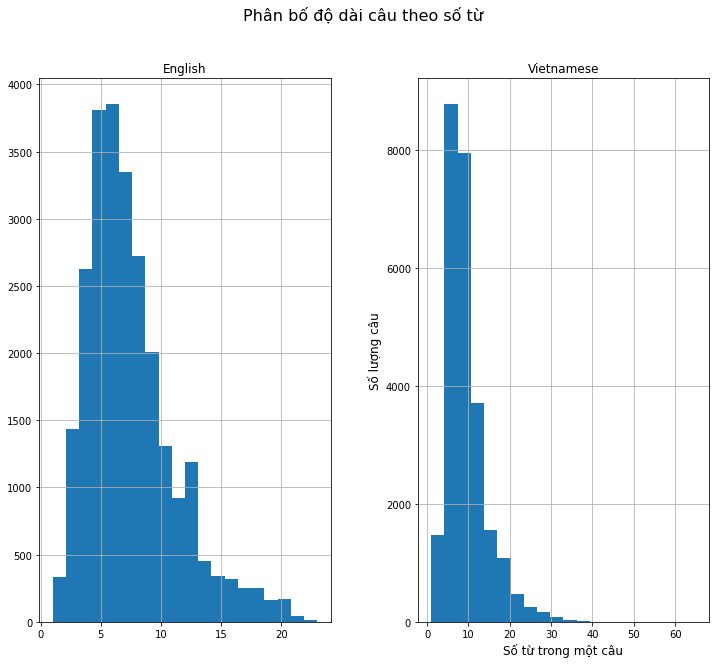

In [19]:
import matplotlib.pyplot as plt
import pandas as pd

# Tạo danh sách độ dài câu (số từ) cho từng ngôn ngữ
en_list = [len(i.split()) for i in df.en]
vi_list = [len(i.split()) for i in df.vi]
# Tạo DataFrame chứa độ dài câu
length_df = pd.DataFrame({'English': en_list, 'Vietnamese': vi_list})
# Vẽ biểu đồ histogram
length_df.hist(bins=20, figsize=(12, 10), color='#1f77b4')
# Thêm tiêu đề và nhãn trục
plt.suptitle("Phân bố độ dài câu theo số từ", fontsize=16)
plt.xlabel("Số từ trong một câu", fontsize=12)
plt.ylabel("Số lượng câu", fontsize=12)

# Hiển thị biểu đồ
plt.show()

# Add token

Thêm vào đầu và cuối câu của dữ liệu tiếng việt mã thông báo “startseq” và “endseq”.
- startseq: Thông báo bắt đầu của chuỗi và trạng thái đầu tiên của vecto ngữ cảnh.
- endseq: Thông báo kết thúc quá trình dự đoán.


In [23]:
df['vi'] = df['vi'].apply(lambda x: 'startseq '+ x + ' endseq')
df.head(10)

,en,vi
0,go on,startseq tiếp tục đi endseq
1,i try,startseq tôi sẽ thử endseq
2,i try,startseq tôi sẽ thử xem sao endseq
3,eat it,startseq ăn đi endseq
4,eat it,startseq ăn nó đi endseq
5,listen,startseq nghe này endseq
6,really,startseq thật sao endseq
7,really,startseq thật á endseq
8,i agree,startseq tôi cũng nghĩ như vậy endseq
9,i agree,startseq tôi đồng ý endseq


# Tokenizer

Đối với dữ liệu tiếng Anh sử dụng thư viện nltk để tách các từ trong một câu.


In [24]:
en_tokenizer = [] # Chứa các câu en đã được tách từ

for i in df['en']:
    en_tokenizer.append(word_tokenize(i))

Đối với dữ liệu tiếng Việt dùng thư viện underthesea để tách các từ trong một câu.


In [25]:
vi_tokenizer = [] # Chứa các câu vn đã được tách từ

for i in df['vi']:
    vi_tokenizer.append(word_tokenize(i))

# Create dictionary

- Từ dữ liệu các từ đã được tách thực hiện tạo từ điển theo mô hình bag of words.
- Mô hình  bag of words tạo danh sách từ điển chứa tất các các từ riêng biệt trong bộ dữ liệu từ đó vecto hóa các câu dựa trên danh sách các từ trong từ điển.


In [26]:
def create_dictionary(data):
    dic = {} # Từ điển chuỗi → chỉ số
    inx ={} # Từ điển chỉ số → chuỗi
    # Tạo đối tượng Collator để sắp xếp chuỗi theo chuẩn tiếng Đức
    collator = icu.Collator.createInstance(icu.Locale('de_DE.UTF-8'))
    # Làm phẳng danh sách lồng nhau (flatten)
    data = list(itertools.chain.from_iterable(data))
    # Lấy các phần tử duy nhất và sắp xếp chúng theo thứ tự của tiếng Đức
    vals = sorted(set(data), key=collator.getSortKey)
    
    for val, key in enumerate(vals):
        dic[key] = val
        inx[val] = key
    
    return dic, inx

- dictionary: từ điển ánh xạ từ từ vựng (string) → chỉ số (int
- inx_dictionary:từ điển ánh xạ ngược từ chỉ số (int) → từ vựng (string)

In [27]:
dictionary_vi, inx_dictionary_vi = create_dictionary(vi_tokenizer)

In [28]:
dictionary_en, inx_dictionary_en = create_dictionary(en_tokenizer)

# Padding

Mô hình nhận vào các vectơ từ có cùng hình dạng và kích thước. Tuy nhiên, các câu trong tập dữ liệu không cùng độ dài với nhau. Vì vậy, quá trình padding sẽ làm cho các vectơ từ có kích thước bằng nhau khi đưa vào mô hình.

Quá trình được thực hiện như sau:
- Từ các vectơ từ được tạo từ quá trình vectơ hóa tìm ra câu có độ dài lớn nhất.
- Thêm các số 0 vào cuối các vectơ từ để có cùng độ dài với vectơ từ có độ dài lớn nhất.


In [29]:
# huyển đổi các chuỗi từ (tokens) sang chuỗi chỉ số (ID) dựa trên một từ điển dic
def generate_sample(data, dic):
    context_word = []
    for seq in data:
        wordset = seq
        context_word.append([dic[j] for j in wordset])
    return context_word

In [30]:
in_seq = generate_sample(en_tokenizer, dictionary_en)
in_seq[:2]

[[4715, 7773], [5413, 11555]]

In [31]:
out_seq = generate_sample(vi_tokenizer, dictionary_vi)
out_seq[:2]

[[5335, 5808, 6096, 1484, 1785], [5335, 5867, 5119, 5734, 1785]]

In [32]:
maxlenght_input = len(max(in_seq, key=len))
in_seq_pad = torch.tensor(tf.keras.preprocessing.sequence.pad_sequences(in_seq, maxlenght_input, padding='post'))

In [33]:
print(maxlenght_input)
in_seq_pad[:2]

22


tensor([[ 4715,  7773,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0],
        [ 5413, 11555,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0]], dtype=torch.int32)

In [35]:
maxlenght_output = len(max(out_seq, key = len))
out_seq_pad = torch.tensor(tf.keras.preprocessing.sequence.pad_sequences(out_seq, maxlenght_output, padding='post'))

In [36]:
print(maxlenght_output)
out_seq_pad[:2]

67


tensor([[5335, 5808, 6096, 1484, 1785,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0],
        [5335, 5867, 5119, 5734, 1785,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0]], dtype=torch.int32)

# Split data

In [37]:
df = shuffle(df, random_state=42)

Dữ liệu được chia theo tỷ lệ train-test-validation là 76:12:12

In [38]:
from sklearn.model_selection import train_test_split

text_pairs = [(i, j) for i, j in zip(df['en'], df['vi'])]

num_val_samples = int(0.12 * len(text_pairs))
num_train_samples = len(text_pairs) - 2 * num_val_samples
train_pairs = text_pairs[:num_train_samples]
val_pairs = text_pairs[num_train_samples : num_train_samples + num_val_samples]
test_pairs = text_pairs[num_train_samples + num_val_samples:]

print(f'{len(text_pairs)} total pairs')
print(f'{len(train_pairs)} training pairs')
print(f'{len(val_pairs)} validation pairs')
print(f'{len(test_pairs)} test pairs')

25545 total pairs
19415 training pairs
3065 validation pairs
3065 test pairs


Chuẩn hóa văn bản đầu vào để phục vụ cho việc huấn luyện mô hình dịch

In [40]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import TextVectorization

sequence_length = maxlenght_input
batch_size = 32

# Khởi tạo lớp vector hóa cho tiếng Anh và tiếng Việt
en_vectorization = TextVectorization(
    # ax_tokens: số lượng từ tối đa trong từ điển (chỉ giữ lại các từ xuất hiện phổ biến nhất).
    max_tokens=len(dictionary_en), output_mode="int", output_sequence_length=maxlenght_input,
)
vi_vectorization = TextVectorization(
    max_tokens=len(dictionary_vi),
    output_mode="int", # mỗi từ sẽ được chuyển thành số nguyên tương ứng (chỉ số từ điển)
    output_sequence_length=maxlenght_input + 1, # độ dài cố định của mỗi câu sau khi chuyển đổi. 
                                                # Các câu ngắn hơn sẽ được đệm (padding), dài hơn sẽ bị cắt.
)

# Tách dữ liệu tiếng Anh và tiếng Việt từ cặp câu song ngữ
train_en_texts = [pair[0] for pair in train_pairs]
train_vi_texts = [pair[1] for pair in train_pairs]
# Huấn luyện bộ vector hóa để xây dựng từ điển nội bộ
en_vectorization.adapt(train_en_texts)
vi_vectorization.adapt(train_vi_texts)

Chuẩn bị dữ liệu cho mô hình dịch . 
Văn bản đầu vào được vector hóa, chia batch, và định dạng sao cho encoder và decoder nhận dữ liệu đúng kiểu.

In [41]:
def format_dataset(en, vi):
    en = en_vectorization(en)  # Chuyển câu tiếng Anh thành chuỗi số nguyên
    vi = vi_vectorization(vi)
    return ({"encoder_inputs": en, "decoder_inputs": vi[:, :-1],}, vi[:, 1:])

def make_dataset(pairs):
    en_texts, vi_texts = zip(*pairs) # # Tách cặp câu thành 2 danh sách riêng
    en_texts = list(en_texts)
    vi_texts = list(vi_texts)
     # Tạo dataset TensorFlow từ 2 danh sách câu
    dataset = tf.data.Dataset.from_tensor_slices((en_texts, vi_texts))
    dataset = dataset.batch(batch_size) # Chia batch với kích thước batch_size
    dataset = dataset.map(format_dataset) # Áp dụng format_dataset lên mỗi batch
    return dataset.shuffle(2048).prefetch(16).cache()
    
# Tạo dataset huấn luyện và kiểm tra
train_ds = make_dataset(train_pairs)
val_ds = make_dataset(val_pairs)

In [42]:
for inputs, targets in train_ds.take(1):
    print(f'inputs["encoder_inputs"].shape: {inputs["encoder_inputs"].shape}')
    print(f'inputs["decoder_inputs"].shape: {inputs["decoder_inputs"].shape}')
    print(f"targets.shape: {targets.shape}")

inputs["encoder_inputs"].shape: (32, 22)
inputs["decoder_inputs"].shape: (32, 22)
targets.shape: (32, 22)


In [43]:
import pandas as pd
import numpy as np
import string
from string import digits

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, LSTM, Input, Embedding, TimeDistributed, Flatten, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint

# Building Transformer Model

In [44]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [45]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [46]:
import random
from typing import Tuple

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch import Tensor

# Mã hóa toàn bộ câu đầu vào
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super(TransformerEncoder, self).__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, mask=None):
        if mask is not None:
            padding_mask = tf.cast(mask[:, tf.newaxis, tf.newaxis, :], dtype="int32")
        attention_output = self.attention(
            query=inputs, value=inputs, key=inputs, attention_mask=padding_mask
        )
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)

# Biến từ → vector và thêm vị trí
class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
        super(PositionalEmbedding, self).__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=vocab_size, output_dim=embed_dim
        )
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=embed_dim
        )
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)

# Sinh câu đầu ra từng bước, dựa trên đầu vào đã mã hóa
class TransformerDecoder(layers.Layer):
    def __init__(self, embed_dim, latent_dim, num_heads, **kwargs):
        super(TransformerDecoder, self).__init__(**kwargs)
        self.embed_dim = embed_dim
        self.latent_dim = latent_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.dense_proj = keras.Sequential(
            [layers.Dense(latent_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, encoder_outputs, mask=None):
        causal_mask = self.get_causal_attention_mask(inputs)
        if mask is not None:
            padding_mask = tf.cast(mask[:, tf.newaxis, :], dtype="int32")
            padding_mask = tf.minimum(padding_mask, causal_mask)

        attention_output_1 = self.attention_1(
            query=inputs, value=inputs, key=inputs, attention_mask=causal_mask
        )
        out_1 = self.layernorm_1(inputs + attention_output_1)

        attention_output_2 = self.attention_2(
            query=out_1,
            value=encoder_outputs,
            key=encoder_outputs,
            attention_mask=padding_mask,
        )
        out_2 = self.layernorm_2(out_1 + attention_output_2)

        proj_output = self.dense_proj(out_2)
        return self.layernorm_3(out_2 + proj_output)

    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)],
            axis=0,
        )
        return tf.tile(mask, mult)

# Mô hình dịch máy Transformer Seq2Seq

In [47]:
embed_dim = 256
latent_dim = 2048
num_heads = 8
vocab_size_in = len(dictionary_en)
vocab_size_out = len(dictionary_vi)
encoder_inputs = keras.Input(shape=(None,), dtype="int64", name="encoder_inputs")
x = PositionalEmbedding(maxlenght_input, vocab_size_in, embed_dim)(encoder_inputs)
encoder_outputs = TransformerEncoder(embed_dim, latent_dim, num_heads)(x)
encoder = keras.Model(encoder_inputs, encoder_outputs)

decoder_inputs = keras.Input(shape=(None,), dtype="int64", name="decoder_inputs")
encoded_seq_inputs = keras.Input(shape=(None, embed_dim), name="decoder_state_inputs")
x = PositionalEmbedding(maxlenght_input, vocab_size_out, embed_dim)(decoder_inputs)
x = TransformerDecoder(embed_dim, latent_dim, num_heads)(x, encoded_seq_inputs)
x = layers.Dropout(0.5)(x)
decoder_outputs = layers.Dense(vocab_size_out, activation="softmax")(x)
decoder = keras.Model([decoder_inputs, encoded_seq_inputs], decoder_outputs)
decoder_outputs = decoder([decoder_inputs, encoder_outputs])

In [48]:
transformer = keras.Model([encoder_inputs, decoder_inputs], 
                          decoder_outputs, 
                          name="transformer")
transformer.summary()
transformer.compile("rmsprop", 
                    loss="sparse_categorical_crossentropy", 
                    metrics=["accuracy"])

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_inputs (InputLayer)     [(None, None)]       0                                            
__________________________________________________________________________________________________
positional_embedding (Positiona (None, None, 256)    3206400     encoder_inputs[0][0]             
__________________________________________________________________________________________________
decoder_inputs (InputLayer)     [(None, None)]       0                                            
__________________________________________________________________________________________________
transformer_encoder (Transforme (None, None, 256)    3155456     positional_embedding[0][0]       
________________________________________________________________________________________

In [49]:
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    "./modelcheckpoint.hdf5",
    monitor='val_accuracy',
    verbose=0,
    save_best_only=True,
    save_weights_only=True,
    mode='auto',
    save_freq='epoch')

In [50]:
epochs = 100

history = transformer.fit(train_ds, 
                     epochs=epochs, 
                     validation_data=val_ds, 
                     callbacks=[model_checkpoint])

Epoch 1/100
607/607 [==============================] - 25s 35ms/step - loss: 2.4384 - accuracy: 0.2987 - val_loss: 2.1455 - val_accuracy: 0.3693
Epoch 2/100
607/607 [==============================] - 21s 34ms/step - loss: 2.0690 - accuracy: 0.3906 - val_loss: 1.9982 - val_accuracy: 0.4073
Epoch 3/100
607/607 [==============================] - 21s 34ms/step - loss: 1.9158 - accuracy: 0.4299 - val_loss: 1.9355 - val_accuracy: 0.4274
Epoch 4/100
607/607 [==============================] - 21s 34ms/step - loss: 1.8026 - accuracy: 0.4572 - val_loss: 1.8582 - val_accuracy: 0.4463
Epoch 5/100
607/607 [==============================] - 21s 34ms/step - loss: 1.7024 - accuracy: 0.4811 - val_loss: 1.8292 - val_accuracy: 0.4503
Epoch 6/100
607/607 [==============================] - 21s 34ms/step - loss: 1.6074 - accuracy: 0.5038 - val_loss: 1.8050 - val_accuracy: 0.4612
Epoch 7/100
607/607 [==============================] - 21s 34ms/step - loss: 1.5223 - accuracy: 0.5225 - val_loss: 1.8003 - val_ac

In [51]:
vi_vocab = vi_vectorization.get_vocabulary()
vi_index_lookup = dict(zip(range(len(vi_vocab)), vi_vocab))
max_decoded_sentence_length = maxlenght_output

def decode_sequence(input_sentence):
    tokenized_input_sentence = en_vectorization([input_sentence])
    decoded_sentence = "startseq"
    for i in range(max_decoded_sentence_length):
        tokenized_target_sentence = vi_vectorization([decoded_sentence])[:, :-1]
        predictions = transformer([tokenized_input_sentence, tokenized_target_sentence])

        if i >= predictions.shape[1]:
            break  # Thoát khỏi vòng lặp nếu i nằm ngoài giới hạn

        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = vi_index_lookup[sampled_token_index]
        decoded_sentence += " " + sampled_token

        if sampled_token == "endseq":
            break
    return decoded_sentence

# Model Evaluation

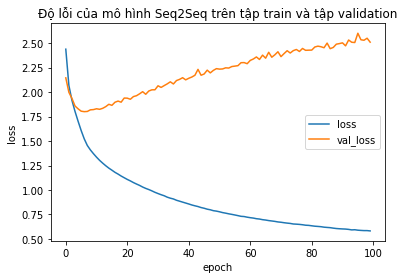

In [52]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Độ lỗi của mô hình Seq2Seq trên tập train và tập validation')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss','val_loss'], loc='center right')
plt.show()

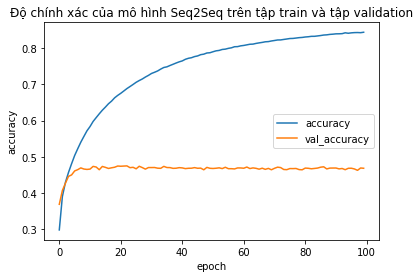

In [59]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Độ chính xác của mô hình Seq2Seq trên tập train và tập validation')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['accuracy','val_accuracy'], loc='center right')
plt.show()

# BLEU SCORE

In [60]:
from nltk.translate.bleu_score import sentence_bleu
data_test = test_pairs

In [61]:
scores_bleu = 0
count_bleu = 0

for i in data_test:
    try:
        predict = decode_sequence(i[0])
        score = sentence_bleu(i[1], predict)
        scores_bleu += score
        count_bleu += 1
        print(count_bleu, end='-')
    except:
        continue

print('\n\nCount_bleu: ', count_bleu)
print('AVERAGE BLEU SCORE: ', scores_bleu/count_bleu)

/opt/conda/lib/python3.7/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


1-2-3-4-5-6-7-8-9-10-11-12-13-14-15-16-17-18-19-20-21-22-23-24-25-26-27-28-29-30-31-32-33-34-35-36-37-38-39-40-41-42-43-44-45-46-47-48-49-50-51-52-53-54-55-56-57-58-59-60-61-62-63-64-65-66-67-68-69-70-71-72-73-74-75-76-77-78-79-80-81-82-83-84-85-86-87-88-89-90-91-92-93-94-95-96-97-98-99-100-101-102-103-104-105-106-107-108-109-110-111-112-113-114-115-116-117-118-119-120-121-122-123-124-125-126-127-128-129-130-131-132-133-134-135-136-137-138-139-140-141-142-143-144-145-146-147-148-149-150-151-152-153-154-155-156-157-158-159-160-161-162-163-164-165-166-167-168-169-170-171-172-173-174-175-176-177-178-179-180-181-182-183-184-185-186-187-188-189-190-191-192-193-194-195-196-197-198-199-200-201-202-203-204-205-206-207-208-209-210-211-212-213-214-215-216-217-218-219-220-221-222-223-224-225-226-227-228-229-230-231-232-233-234-235-236-237-238-239-240-241-242-243-244-245-246-247-248-249-250-251-252-253-254-255-256-257-258-259-260-261-262-263-264-265-266-267-268-269-270-271-272-273-274-275-276-277-

# Predict

In [64]:
test_en_texts = [pair for pair in data_test]
for _ in range(10):
    input_sentence = random.choice(test_en_texts)
    translated = decode_sequence(input_sentence[0])
    print('en: ', input_sentence[0])
    print('actual: ', input_sentence[1])
    print('predict: ', translated)
    print('\n------------------------------------------------------------------------\n')

en:  its really boring
actual:  startseq thật sự là rất tẻ nhạt endseq
predict:  startseq điều này thật sự rất tiếc endseq

------------------------------------------------------------------------

en:  im very busy now
actual:  startseq bây giờ tôi rất bận rộn endseq
predict:  startseq tôi đang rất bận endseq

------------------------------------------------------------------------

en:  you are getting to the good part
actual:  startseq bạn đang nhận được phần tốt endseq
predict:  startseq phần này được endseq

------------------------------------------------------------------------

en:  im looking forward to it
actual:  startseq tôi rất mong chờ điều đó endseq
predict:  startseq tôi mong đợi điều đó endseq

------------------------------------------------------------------------

en:  come on lets get started
actual:  startseq bắt đầu thôi endseq
predict:  startseq nào bắt đầu thôi endseq

------------------------------------------------------------------------

en:  if you see tom

In [69]:
import pandas as pd
import tensorflow as tf
import keras
from keras import layers
import numpy as np
from sklearn.model_selection import train_test_split
from keras.layers import LSTM, Dense,Input, Embedding
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string

import warnings
warnings.filterwarnings('ignore')

In [70]:
## thêm dấu START và END vào câu mục tiêu
df['vi'] = df['vi'].apply(lambda x: "START_ " + x + " _END")

In [71]:
# đếm độ dài của câu tiếng anh và tiếng việt
df['en_length'] = df['en'].apply(lambda x: len(x.split(' ')))
df['vi_length'] = df['vi'].apply(lambda x: len(x.split(' ')))

df.head()

,en,vi,en_length,vi_length
0,go on,START_ tiếp tục đi _END,2,5
1,i try,START_ tôi sẽ thử _END,2,5
2,i try,START_ tôi sẽ thử xem sao _END,2,7
3,eat it,START_ ăn đi _END,2,4
4,eat it,START_ ăn nó đi _END,2,5


In [72]:
print("Maximum length of English Sentence: ", max(df['en_length']))
print("Maximum length of Vietnam Sentence: ",max(df['vi_length']))

Maximum length of English Sentence:  22
Maximum length of Vietnam Sentence:  67


In [73]:
### Nhận từ vựng tiếng Anh và tiếng Việt
all_en_words=set()
for en in df['en']:
    for word in en.split():
        if word not in all_en_words:
            all_en_words.add(word)

all_vi_words=set()
for vi in df['vi']:
    for word in vi.split():
        if word not in all_vi_words:
            all_vi_words.add(word)
            

print("toral English words: ",len(all_en_words))
print('total Vietnam words: ',len(all_vi_words))

toral English words:  12503
total Vietnam words:  6669


In [ ]:
## chỉ sử dụng câu có độ dài dưới 21
mask1 = df['en_length'] < 21
mask2 = df['vi_length'] < 21
data = df[mask1 & mask2]
data.shape

(24057, 4)

In [75]:
print("maximum length of Vietnam Sentence ",max(data['vi_length']))
print("maximum length of English Sentence ",max(data['en_length']))

maximum length of Vietnam Sentence  20
maximum length of English Sentence  20


In [76]:
input_words = sorted(list(all_en_words))
target_words = sorted(list(all_vi_words))
num_encoder_tokens = len(all_en_words)
num_decoder_tokens = len(all_vi_words)

num_encoder_tokens, num_decoder_tokens

(12503, 6669)

In [77]:
num_decoder_tokens += 1 # padding bằng không
input_token_index = dict([(word, i+1) for i, word in enumerate(input_words)])
target_token_index = dict([(word, i+1) for i, word in enumerate(target_words)])
print("Token for accelerating is: ",input_token_index['academy'])

Token for accelerating is:  50


In [78]:
reverse_input_char_index = dict((i, word) for word, i in input_token_index.items())
reverse_target_char_index = dict((i, word) for word, i in target_token_index.items())
print("Character for toker 50 is: ",reverse_input_char_index[50])

Character for toker 50 is:  academy


In [79]:
# splitting data
X_, y_ = df['en'], df['vi']
X_train, X_test, y_train, y_test = train_test_split(X_, y_, test_size = 0.2,random_state=42)
print("Total number of training data: ",X_train.shape[0])
print("Toral number of testing data: ",X_test.shape[0])

Total number of training data:  20436
Toral number of testing data:  5109


# Kiến trúc Encoder-Decoder LSTM

In [80]:
latent_dim = 300  # Kích thước của vector ẩn trong LSTM

# ENCODER (Bộ mã hóa)
encoder_inputs = Input(shape=(None,))  # Đầu vào của encoder: chuỗi các chỉ số từ (dạng số nguyên)
enc_emb = Embedding(num_encoder_tokens, latent_dim, mask_zero=True)(encoder_inputs)  
# Lớp nhúng (embedding) chuyển từ chỉ số từ sang vector dense có kích thước latent_dim
# mask_zero=True để LSTM bỏ qua các padding (0)

encoder_lstm = LSTM(latent_dim, return_state=True)  
# LSTM trả về cả trạng thái ẩn và trạng thái ô nhớ (cell state)

encoder_outputs, state_h, state_c = encoder_lstm(enc_emb)  
# encoder_outputs: không sử dụng ở đây
# state_h: trạng thái ẩn cuối cùng
# state_c: trạng thái ô nhớ cuối cùng

encoder_states = [state_h, state_c]  
# Chúng ta sẽ truyền các trạng thái này sang decoder làm trạng thái khởi tạo


# DECODER (Bộ giải mã)
decoder_inputs = Input(shape=(None,))  # Đầu vào của decoder (chuỗi chỉ số từ đầu ra)
dec_emb_layer = Embedding(num_decoder_tokens, latent_dim, mask_zero=True)  # Lớp nhúng cho decoder

dec_emb = dec_emb_layer(decoder_inputs)  # Tạo embedding từ đầu vào decoder

# LSTM của decoder nhận initial_state là encoder_states
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=encoder_states)

# Lớp Dense dùng để dự đoán xác suất cho từng từ trong từ vựng đầu ra
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Định nghĩa mô hình huấn luyện:
# Đầu vào: encoder_inputs (câu nguồn) và decoder_inputs (câu đích )
# Đầu ra: decoder_outputs (chuỗi dịch hoàn chỉnh)
model = tf.keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)

# In cấu trúc mô hình
model.summary()
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics = ['accuracy'])

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_6 (Embedding)         (None, None, 300)    3750900     input_7[0][0]                    
__________________________________________________________________________________________________
embedding_7 (Embedding)         (None, None, 300)    2001000     input_8[0][0]                    
____________________________________________________________________________________________

In [81]:
def generate_batch(X=X_train, y=y_train, batch_size=128):
    ''' Hàm sinh từng batch dữ liệu huấn luyện cho mô hình '''
    while True:
        for j in range(0, len(X), batch_size):
            encoder_input_data = np.zeros((batch_size, max_length_src), dtype='float32')
            decoder_input_data = np.zeros((batch_size, max_length_tar), dtype='float32')
            decoder_target_data = np.zeros((batch_size, max_length_tar, num_decoder_tokens), dtype='float32')

            for i, (input_text, target_text) in enumerate(zip(X[j:j+batch_size], y[j:j+batch_size])):
                # --- Xử lý chuỗi đầu vào (câu nguồn)
                for t, word in enumerate(input_text.split()):
                    if t < max_length_src:  # Giới hạn độ dài
                        encoder_input_data[i, t] = input_token_index.get(word, 0)

                # --- Xử lý chuỗi đầu ra (câu đích)
                target_words = target_text.split()
                for t, word in enumerate(target_words):
                    if t < max_length_tar:
                        decoder_input_data[i, t] = target_token_index.get(word, 0)

                    if 0 < t < max_length_tar:
                        decoder_target_data[i, t - 1, target_token_index.get(word, 0)] = 1.0

            yield ([encoder_input_data, decoder_input_data], decoder_target_data)


In [82]:
train_samples = len(X_train)
val_samples = len(X_test)
batch_size = 32
epochs = 100

In [83]:
ml = model.fit_generator(generator = generate_batch(X_train, y_train, batch_size = batch_size),
                    steps_per_epoch = train_samples//batch_size,
                    epochs=epochs,
                    validation_data = generate_batch(X_test, y_test, batch_size = batch_size),
                    validation_steps = val_samples//batch_size)

Epoch 1/100
638/638 [==============================] - 35s 46ms/step - loss: 2.8515 - accuracy: 0.1349 - val_loss: 2.6047 - val_accuracy: 0.1705
Epoch 2/100
638/638 [==============================] - 27s 43ms/step - loss: 2.5392 - accuracy: 0.1889 - val_loss: 2.4353 - val_accuracy: 0.2091
Epoch 3/100
638/638 [==============================] - 27s 43ms/step - loss: 2.3641 - accuracy: 0.2257 - val_loss: 2.3227 - val_accuracy: 0.2398
Epoch 4/100
638/638 [==============================] - 27s 43ms/step - loss: 2.2215 - accuracy: 0.2590 - val_loss: 2.2241 - val_accuracy: 0.2676
Epoch 5/100
638/638 [==============================] - 27s 43ms/step - loss: 2.0968 - accuracy: 0.2873 - val_loss: 2.1561 - val_accuracy: 0.2864
Epoch 6/100
638/638 [==============================] - 27s 43ms/step - loss: 1.9877 - accuracy: 0.3116 - val_loss: 2.1093 - val_accuracy: 0.2985
Epoch 7/100
638/638 [==============================] - 27s 43ms/step - loss: 1.8876 - accuracy: 0.3339 - val_loss: 2.0739 - val_ac

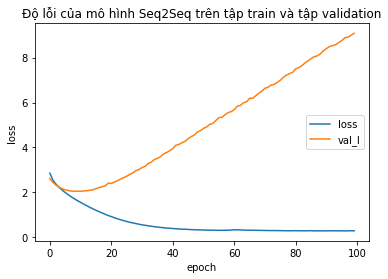

In [84]:
plt.plot(ml.history['loss'])
plt.plot(ml.history['val_loss'])
plt.title('Độ lỗi của mô hình Seq2Seq trên tập train và tập validation')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss','val_l'], loc='center right')
plt.show()

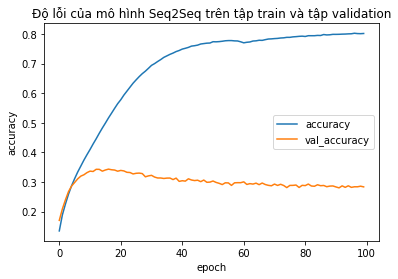

In [85]:
plt.plot(ml.history['accuracy'])
plt.plot(ml.history['val_accuracy'])
plt.title('Độ lỗi của mô hình Seq2Seq trên tập train và tập validation')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['accuracy','val_accuracy'], loc='center right')
plt.show()

In [86]:
# Mô hình encoder dùng để mã hóa câu đầu vào thành vector trạng thái (thought vector)
encoder_model = tf.keras.Model(encoder_inputs, encoder_states)

# Thiết lập decoder để suy diễn (dự đoán từng bước)
# Input giữ trạng thái ẩn (hidden state) và trạng thái ô nhớ (cell state) từ bước trước
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

# Nhúng (embedding) chuỗi đầu vào cho decoder
dec_emb2 = dec_emb_layer(decoder_inputs)

# Dự đoán từ tiếp theo trong chuỗi, sử dụng trạng thái từ bước trước
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=decoder_states_inputs)

# Cập nhật lại trạng thái sau khi chạy decoder một bước
decoder_states2 = [state_h2, state_c2]

# Lớp Dense với softmax để tạo phân phối xác suất trên từ vựng đầu ra
decoder_outputs2 = decoder_dense(decoder_outputs2)

# Mô hình decoder cho suy diễn
decoder_model = tf.keras.Model(
    [decoder_inputs] + decoder_states_inputs,  # đầu vào: token hiện tại + trạng thái trước
    [decoder_outputs2] + decoder_states2       # đầu ra: token tiếp theo + trạng thái mới
)

def decode_sequence(input_seq):
    # Mã hóa câu đầu vào thành vector trạng thái (state)
    states_value = encoder_model.predict(input_seq)

    # Tạo chuỗi đầu vào đầu tiên cho decoder (bắt đầu với token START_)
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = target_token_index['START_']

    # Biến lưu kết quả câu đã dịch
    decoded_sentence = ''
    stop_condition = False

    while not stop_condition:
        # Dự đoán token tiếp theo dựa trên trạng thái hiện tại
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # Lấy token có xác suất cao nhất
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]  # chuyển từ index về từ

        # Thêm từ vừa chọn vào câu dịch
        decoded_sentence += ' ' + sampled_char

        # Dừng lại nếu gặp token kết thúc hoặc quá dài
        if (sampled_char == '_END' or len(decoded_sentence) > 100):
            stop_condition = True

        # Tạo chuỗi đầu vào mới cho decoder (token vừa chọn)
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        # Cập nhật trạng thái cho bước tiếp theo
        states_value = [h, c]

    return decoded_sentence

In [87]:
from nltk.translate.bleu_score import sentence_bleu
train_gen = generate_batch(X_test, y_test, batch_size = 1)
k = -1

In [91]:
from nltk.translate.bleu_score import sentence_bleu
import numpy as np

bleu_scores = []

for k in range(50):
    # Lấy batch dữ liệu và dự đoán
    (input_seq, actual_output), _ = next(train_gen)
    decoded_sentence = decode_sequence(input_seq)

    # Lấy câu đầu vào và câu đích thực tế
    input_sentence = X_train[k:k+1].values[0]
    actual = y_train[k:k+1].values[0][6:-4]  # loại START_ và _END
    predict = decoded_sentence[:-4]

    # Tính BLEU
    reference = [actual.split()]
    hypothesis = predict.split()
    score = sentence_bleu(reference, hypothesis)
    bleu_scores.append(score)

    # In thông tin từng câu
    print(f"\nCâu {k+1}:")
    print("📝 Câu gốc:", input_sentence)
    print("✅ Dịch thực tế:", actual)
    print("🤖 Dịch mô hình:", predict)
    print("🎯 BLEU Score:", score)

# Tính BLEU trung bình
average_bleu = np.mean(bleu_scores)
print("\n📊 Trung bình BLEU Score:", average_bleu)


Câu 1:
📝 Câu gốc: i didnt realize till i visited australia how small japan really is
✅ Dịch thực tế:  tôi đã không nhận ra nhật bản nhỏ đến thế nào cho đến khi tôi tới úc 
🤖 Dịch mô hình:  chứng chất quan hệ tương tự lặn đưa ra một chất năng 
🎯 BLEU Score: 0.3542000795248998

Câu 2:
📝 Câu gốc: you win some you lose some
✅ Dịch thực tế:  bạn được cái này thì lại mất cái khác 
🤖 Dịch mô hình:  không phải làm gì thế nào không 
🎯 BLEU Score: 0

Câu 3:
📝 Câu gốc: i really like him
✅ Dịch thực tế:  tôi thực sự thích anh ta 
🤖 Dịch mô hình:  điều đó thú vị sai 
🎯 BLEU Score: 0

Câu 4:
📝 Câu gốc: tom still hasnt arrived
✅ Dịch thực tế:  tom vẫn chưa đến 
🤖 Dịch mô hình:  anh ta là một trong những con người khác trên máy vắng người thì bạn 
🎯 BLEU Score: 0

Câu 5:
📝 Câu gốc: lets try again
✅ Dịch thực tế:  chúng ta hãy thử lại nhé 
🤖 Dịch mô hình:  và tôi yêu nhà chỉ trích hành lang 
🎯 BLEU Score: 0

Câu 6:
📝 Câu gốc: i dont think tom did this
✅ Dịch thực tế:  tôi không nghĩ là tom đã làm việc